# How to learn a graph from smooth signals [Kalofolias, 2016]

In [1]:
from scipy import sparse, spatial
from sklearn import metrics
import utils
import learn_graph as lg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Generate inverse covariance matrix

In [2]:
N = 256 # Number of nodes
Ne = int(N * (N - 1) / 2)

In [3]:
Q = sparse.rand(N, N, density=0.005)
Q = Q.toarray()
Q = (Q + Q.T)/2 
e, u = np.linalg.eig(Q)
Q = Q + (np.abs(min(e)) + 1) * np.eye(N) # Enforce positive-definitedness

## Generate ground-truth graph

In [4]:
W_gt = abs(Q - np.diag(np.diag(Q)))
G_gt = nx.from_numpy_matrix(W_gt)
pos = nx.spring_layout(G_gt)

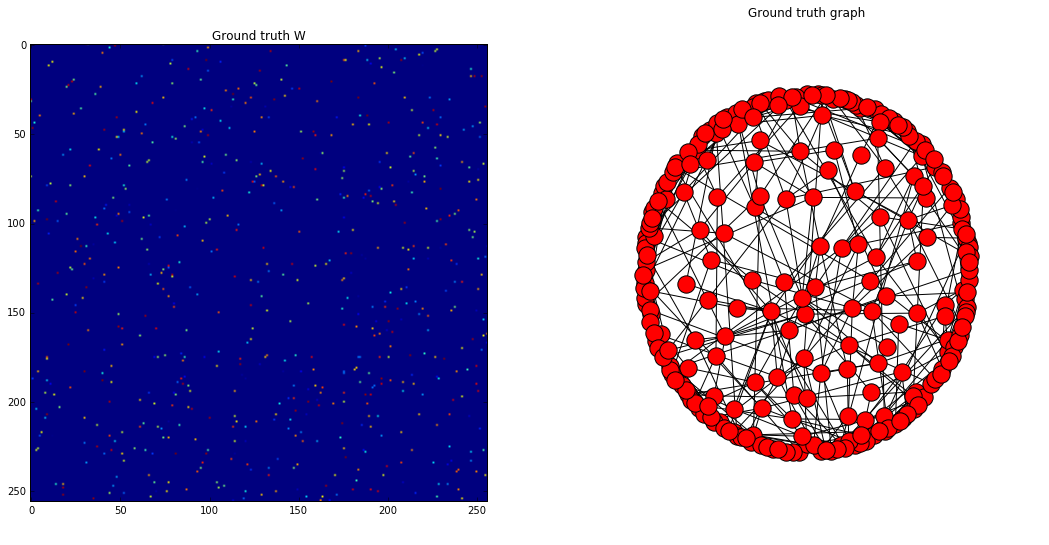

In [5]:
plt.figure(figsize=(18, 9))

plt.subplot(1,2,1)
plt.imshow(W_gt)
plt.title("Ground truth W")

plt.subplot(1,2,2)
plt.title("Ground truth graph")
nx.draw(G_gt, pos=pos)

## Generate samples

In [6]:
N_samples = 100
X = np.random.multivariate_normal(mean=np.zeros((N,)), 
                                  cov=np.linalg.inv(Q), 
                                  size=N_samples).T

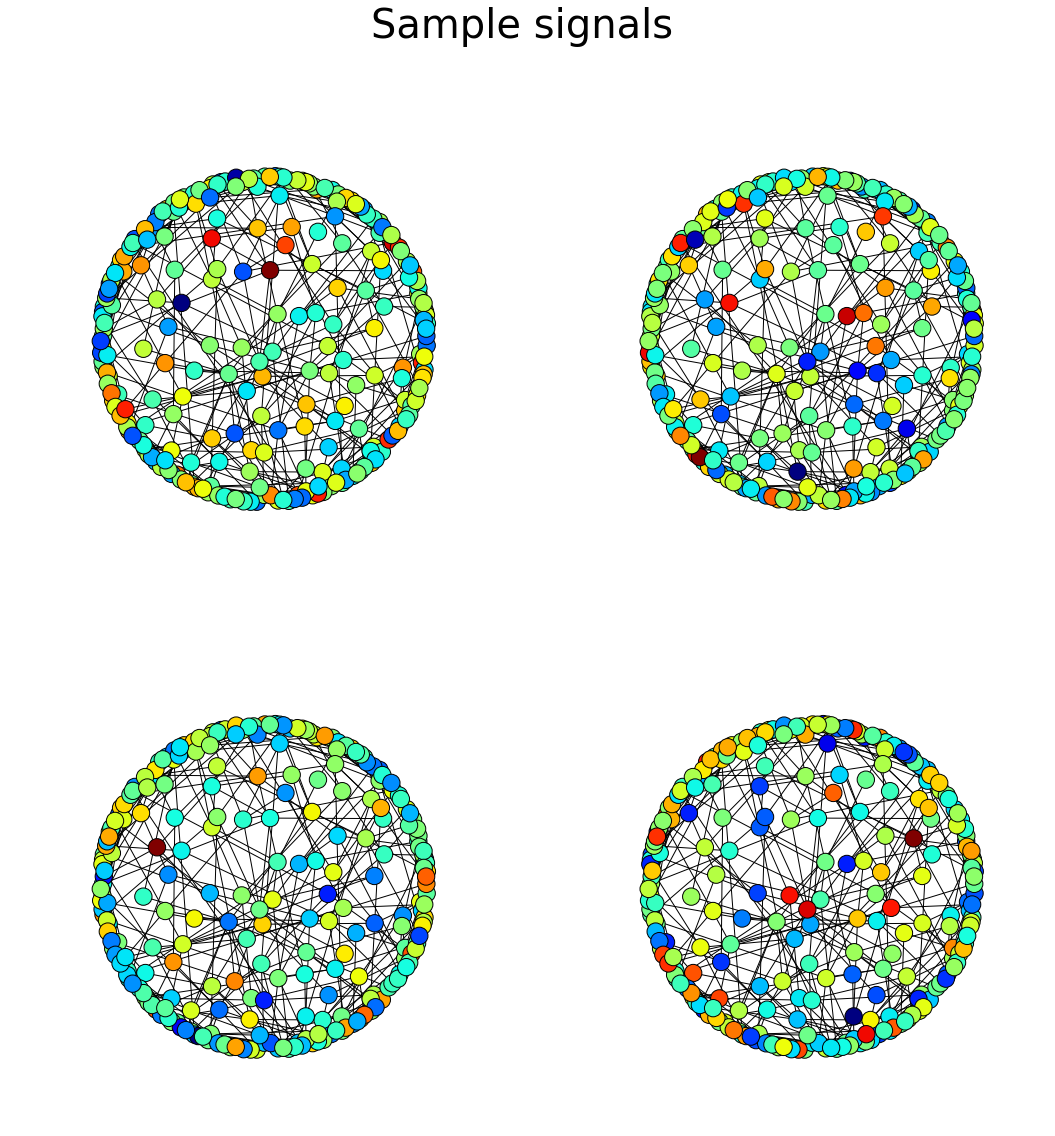

In [7]:
plt.figure(figsize=(18, 18))
plt.suptitle('Sample signals', fontsize=40)

plt.subplot(2,2,1)
nx.draw(G_gt, pos=pos, node_color=X[:,0])

plt.subplot(2,2,2)
nx.draw(G_gt, pos=pos, node_color=X[:,1])

plt.subplot(2,2,3)
nx.draw(G_gt, pos=pos, node_color=X[:,2])

plt.subplot(2,2,4)
nx.draw(G_gt, pos=pos, node_color=X[:,3])

## Solve the optimization problem

In [8]:
# Solve the problem
W, problem = lg.log_degree_barrier(X, dist_type='sqeuclidean', alpha=1, beta=1, retall=True, verbosity='LOW')

Solution found after 1000 iterations:
    objective function f(sol) = 1.577203e+03
    stopping criterion: MAXIT


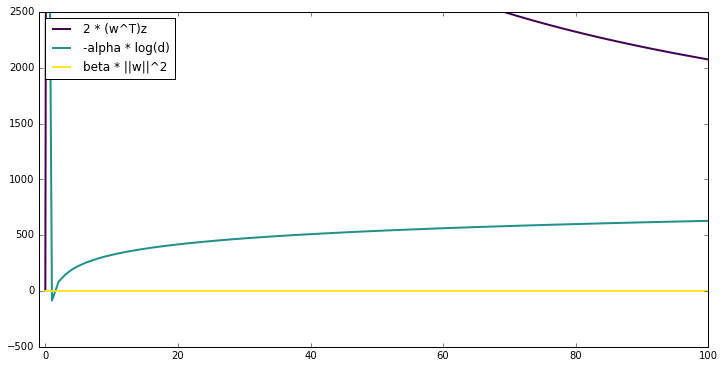

In [9]:
# Display objective values
fig, ax = utils.plot_objectives(problem['objective'], 
                                labels=['2 * (w^T)z', 
                                        '-alpha * log(d)',
                                        'beta * ||w||^2'])
ax.set_xlim([-1, 100])
ax.set_ylim([-500, 2500])
plt.show()

## Recover learned graph

In [10]:
W_thresh = np.max(W_gt) * W / np.max(W)
W_thresh[W_thresh < np.min(W_gt)] = 0
G_learned = nx.from_numpy_matrix(W_thresh)

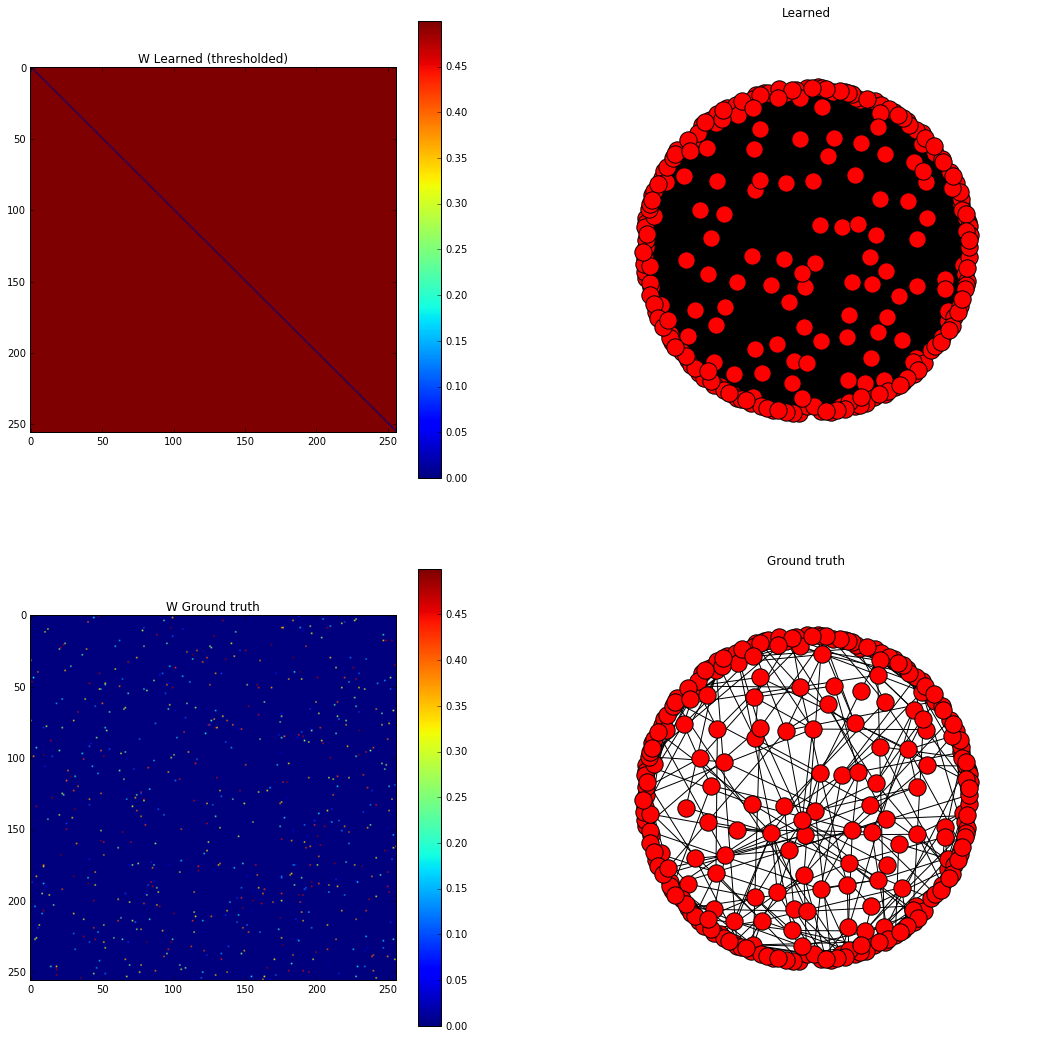

In [11]:
plt.figure(figsize=(18, 18))
plt.subplot(2,2,1)
plt.imshow(W_thresh)
plt.colorbar()
plt.title('W Learned (thresholded)')

plt.subplot(2,2,2)
nx.draw(G_learned, pos=pos)
plt.title('Learned')

plt.subplot(2,2,3)
plt.imshow(W_gt)
plt.colorbar()
plt.title('W Ground truth')

plt.subplot(2,2,4)
nx.draw(G_gt, pos=pos)
plt.title('Ground truth')

plt.show()

In [12]:
f_score = metrics.f1_score((spatial.distance.squareform(W_gt) > 0), 
                           (spatial.distance.squareform(W) > 0))
print("F-score = {:.2f}".format(f_score))

F-score = 0.02


## Compare spectra of the Laplacian matrices

In [13]:
L = utils.create_laplacian(W, lap_type='normalized', 
                           sparse_flag=False)
L_gt = utils.create_laplacian(W_gt, lap_type='normalized', 
                           sparse_flag=False)
e, _ = np.linalg.eigh(L)
e = np.sort(e)
e_gt, _ = np.linalg.eigh(L_gt)
e_gt = np.sort(e_gt)

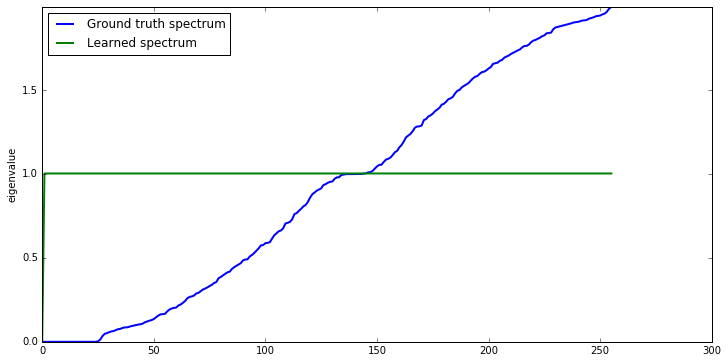

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(e_gt, linewidth=2)
plt.plot(e, linewidth=2)
plt.ylabel('eigenvalue')
plt.ylim([0,max(np.max(e_gt), np.max(e))])
plt.legend(['Ground truth spectrum', 'Learned spectrum'], loc='best')

plt.show()